<a href="https://colab.research.google.com/github/sujathasivaraman/mlai/blob/main/krithik_cnn_chicken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title RUN in GPU mode
# {"display-mode":"form", "form-width":"25%"}
#@markdown ##**BEFORE RUNNING ANY CODE, please change your Hardware Accelerator to GPU to train faster!**</h2>
#@markdown 1. Click on the **Runtime** menu at the top of the screen.
#@markdown 2. Click **Change Runtime Type**.
#@markdown 3. Choose **T4 GPU** under **Hardware Accelerator**.

#@markdown Once you've done that, run this code cell to check you're correctly connected!

import tensorflow as tf
from IPython.display import Markdown

if tf.test.gpu_device_name():
  display(Markdown("###✅ GPU connected!"))
else:
  display(Markdown("""
###❌ No GPU found!
If you're running into GPU limits when you try to switch, here are some suggestions:
  - Wait 12-24 hours for the limits to reset.
  - Share your copy of the notebook with another Google account that hasn't met the limit, and work through the notebook with that account.
  - Look into a paid subscription or paying for compute units as you go.
  """))


###❌ No GPU found!
If you're running into GPU limits when you try to switch, here are some suggestions:
  - Wait 12-24 hours for the limits to reset.
  - Share your copy of the notebook with another Google account that hasn't met the limit, and work through the notebook with that account.
  - Look into a paid subscription or paying for compute units as you go.
  

In [ ]:
#@title Chickens Google Drive :  Run this to load images and imports! {"display-mode":"form", "form-width":"25%"}
import tensorflow as tf
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np  # Added for numerical operations
from tensorflow.keras import layers, models, optimizers
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Constants
IMG_SHAPE = (160, 160)  # Tuple format
BATCH_SIZE = 32  # More manageable batch size
zip_path = '/content/drive/My Drive/Dataset/chicken_notachicken.zip'
# extract_dir = '/content/drive/My Drive/Dataset/cats_and_dogs_filtered_extracted'
# zip_path = '/content/drive/My Drive/Dataset/cats_and_dogs_filtered.zip'
extract_dir = '/content/drive/MyDrive/Dataset'

# Create extraction directory
os.makedirs(extract_dir, exist_ok=True)  # Safer directory creation

# # Extract ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# Dataset directories
base_dir = os.path.join(extract_dir, 'chicken_notachicken')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print("Base directory:", base_dir)
print("Train Directory: ", train_dir)
print("Validation Directory: ", validation_dir)
print("Test Directory: ", test_dir)

# Verify directories
assert os.path.exists(train_dir), f"Train directory not found: {train_dir}"
assert os.path.exists(validation_dir), f"Validation directory not found: {validation_dir}"
assert os.path.exists(test_dir), f"Test directory not found: {test_dir}"

Mounted at /content/drive
Base directory: /content/drive/MyDrive/Dataset/chicken_notachicken
Train Directory:  /content/drive/MyDrive/Dataset/chicken_notachicken/train
Validation Directory:  /content/drive/MyDrive/Dataset/chicken_notachicken/validation
Test Directory:  /content/drive/MyDrive/Dataset/chicken_notachicken/test


In [ ]:
# Create data generators with normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = next(train_datagen.flow_from_directory(
    batch_size=76,
    directory=train_dir,
    shuffle=True,
    target_size=IMG_SHAPE, #(150,150)
    class_mode='binary')
)

validation_data = next(val_datagen.flow_from_directory(
    batch_size=5,
    directory=validation_dir,
    shuffle=False,
    target_size=IMG_SHAPE, #(150,150)
    class_mode='binary')
)

test_data = next(test_datagen.flow_from_directory(
    batch_size=25,
    directory=test_dir,
    shuffle=False,
    target_size=IMG_SHAPE, #(150,150)
    class_mode=None)
)

Found 76 images belonging to 2 classes.
Found 5 images belonging to 2 classes.
Found 24 images belonging to 1 classes.


In [ ]:
# Optional: Load sample batch for inspection
sample_images = train_data
print("Sample batch shape:", sample_images.shape)
# print("Sample labels shape:", sample_labels.shape)

labels = ['Chicken', 'Not a Chicken']

# Visualize sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    # plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')
plt.show()



AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
cd_train_inputs, cd_train_labels = train_data
cd_test_inputs, cd_test_labels = validation_data

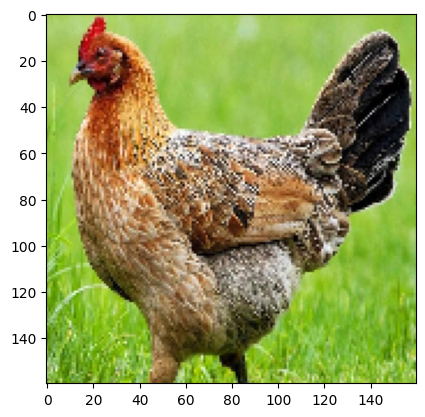

Label: 0.0


In [ ]:
#@title Display data or images
index = np.random.randint(len(cd_train_inputs))
plt.imshow(cd_train_inputs[index])
plt.show()
print("Label:", cd_train_labels[index])
#print("Label(train):", "Chicken" if cd_train_labels[index] <= 0 else "Not a Chicken")

# # Optional: Load sample batch for inspection
# sample_images, sample_labels = train_data
# print("Sample batch shape:", sample_images.shape)
# print("Sample labels shape:", sample_labels.shape)

# # Visualize sample images
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(sample_images[i])
#     plt.title(f"Label: {sample_labels[i]}")
#     plt.axis('off')
# plt.show()

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
pretrained_model.trainable = False

In [ ]:
cd_train_inputs, cd_train_labels = train_data
cd_test_inputs, cd_test_labels = validation_data

model = models.Sequential([
  pretrained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(1)
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(cd_train_inputs, cd_train_labels,
                    epochs=10,
                    validation_data=validation_data)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3442 - loss: 1.0147 - val_accuracy: 0.6000 - val_loss: 0.8638
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.3561 - loss: 1.0050 - val_accuracy: 0.6000 - val_loss: 0.8549
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.4332 - loss: 0.9382 - val_accuracy: 0.6000 - val_loss: 0.8485
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.4620 - loss: 0.8951 - val_accuracy: 0.6000 - val_loss: 0.8444
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 748ms/step - accuracy: 0.5012 - loss: 0.8920 - val_accuracy: 0.4000 - val_loss: 0.8424
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.4753 - loss: 0.8778 - val_accuracy: 0.4000 - val_loss: 0.8421
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.5588 - loss: 0.7901 - val_accuracy: 0.6000 - val_loss: 0.8438
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.5681 - loss: 0.8084 - val_accuracy: 0.6000 - val_loss: 0

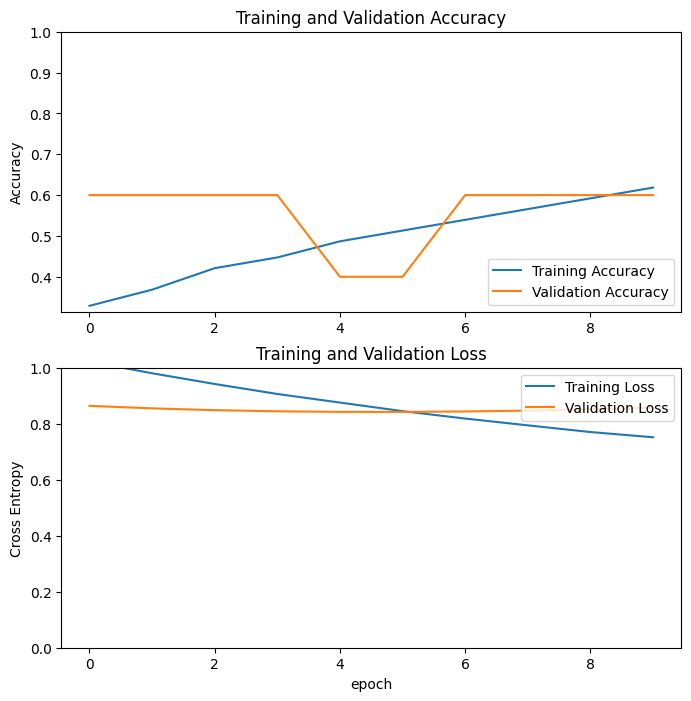

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model.predict(test_data)

pred_cat = []

for i in range(len(predictions)):
  if predictions[i] < 0:
    pred_cat.append("Chicken")
  if predictions[i] > 0:
    pred_cat.append("Not a Chicken")

pred_cat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


['Not a Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Not a Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Not a Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Chicken',
 'Not a Chicken',
 'Not a Chicken',
 'Not a Chicken',
 'Not a Chicken',
 'Not a Chicken']

ValueError: num must be an integer with 1 <= num <= 9, not 10

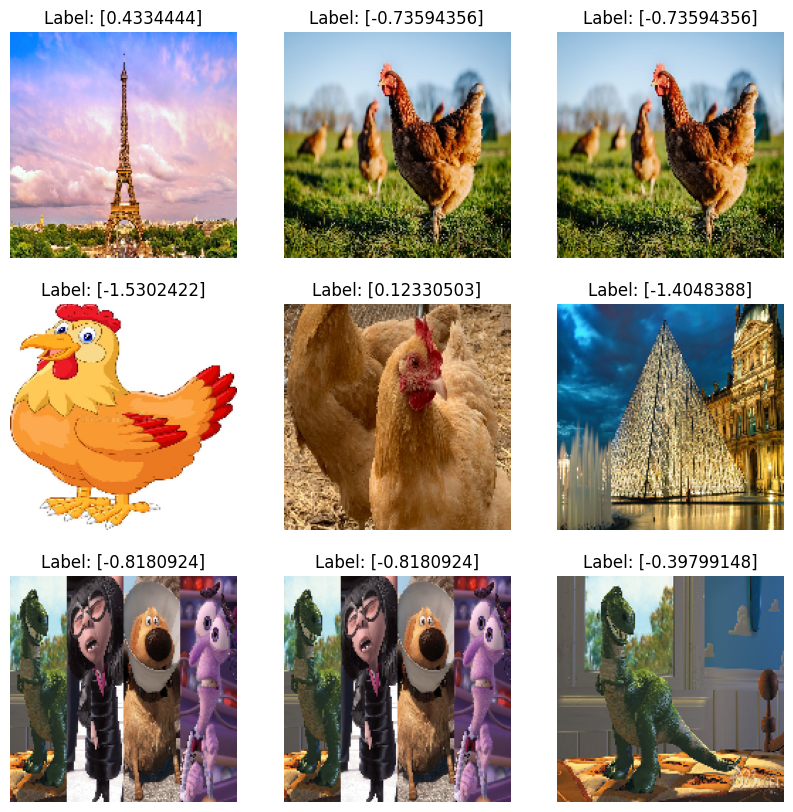

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[i])
    plt.title (f"Label: {predictions[i]}")
    #plt.title(f"Label: {pred_cat[i]}")
    plt.axis('off')
plt.show()